In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error, mean_absolute_error

In [2]:
title='RNN BID 7-2-1'
train_ratio=0.7
test_ratio=0.2

In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../BID Historical Data.csv', index_col='Date', parse_dates=['Date'])

In [4]:
df=df.iloc[::-1]
df['Price']=df['Price'].replace(',','',regex=True).astype(float)
df=df['Price']
df1=df.reset_index()['Price']


In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(train_ratio * len(df1))
test_size = int(test_ratio * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [10]:
# 8. Define LSTM Model
unit_model=20
model = Sequential()
model.add(SimpleRNN(unit_model,activation='relu',return_sequences=True,input_shape=(time_step, 1)))
model.add(SimpleRNN(unit_model,activation='relu',return_sequences=True))
model.add(SimpleRNN(unit_model,activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
23/23 [==============================] - 2s 23ms/step - loss: 0.0360 - val_loss: 0.0080
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 3/100
23/23 [==============================] - 0s 12ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 4/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 5/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 6/100
23/23 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 7/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 8/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 9/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 10/100
23/23 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0024

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 5ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
val_len=len(val_data)
print(val_len)

111


In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=val_len-60
i=0
while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.784601]
52
1 day input [0.85731319 0.8866324  0.87881394 0.86513164 0.88272317 0.88272317
 0.89054162 0.89054162 0.89054162 0.87881394 0.88272317 0.86317703
 0.88272317 0.86904087 0.83190321 0.82017552 0.82017552 0.84167628
 0.82213014 0.84363089 0.82799398 0.82017552 0.82799398 0.81235707
 0.79281093 0.78694709 0.80844784 0.80062939 0.78499247 0.79476554
 0.78303786 0.83190321 0.84754012 0.84363089 0.84363089 0.84363089
 0.83972166 0.84363089 0.83581244 0.82994859 0.82017552 0.82017552
 0.79867477 0.78499247 0.79476554 0.78108325 0.80062939 0.79672016
 0.80453861 0.79281093 0.78460097]
1 day output [[0.7789328]]
2 day input [0.8866324  0.87881394 0.86513164 0.88272317 0.88272317 0.89054162
 0.89054162 0.89054162 0.87881394 0.88272317 0.86317703 0.88272317
 0.86904087 0.83190321 0.82017552 0.82017552 0.84167628 0.82213014
 0.84363089 0.82799398 0.82017552 0.82799398 0.81235707 0.79281093
 0.78694709 0.80844784 0.80062939 0.78499247 0.79476554 0.78303786
 0.83190321 0.84754012 0.8436

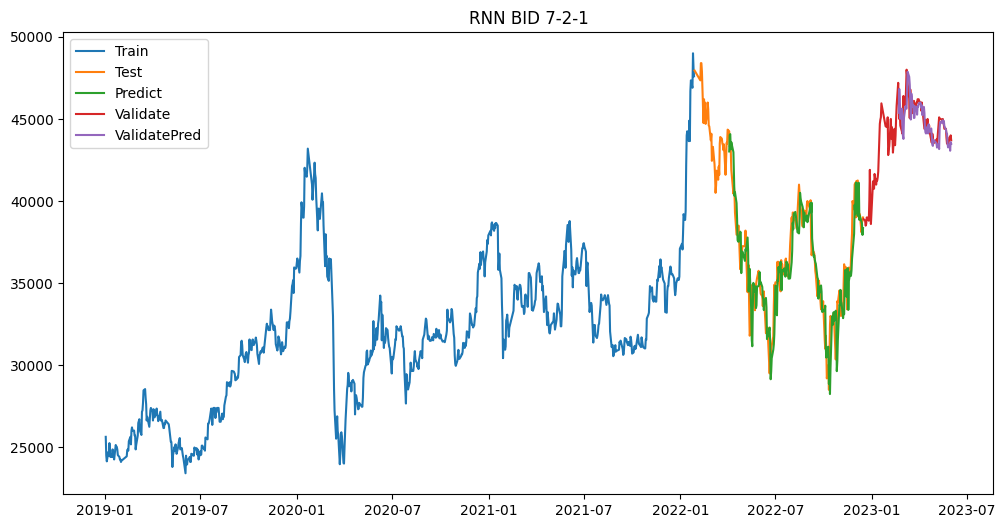

In [16]:
# 14.Vẽ hình
#train
plt.figure(figsize=(12,6))
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
#prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
#plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
#plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.title(title)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

In [17]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
#Thực hiện inverse transform để đưa dữ liệu về lại đơn vị ban đầu và tính RMSE và MAPE
y_test_scaleback=scaler.inverse_transform(ytest.reshape(-1,1))
test_mape = mean_absolute_percentage_error(y_test_scaleback, y_pred)*100
test_rmse = np.sqrt(mean_squared_error(y_test_scaleback,y_pred))
test_mae=mean_absolute_error(y_test_scaleback,y_pred)
y_val_scaleback=scaler.inverse_transform(yval.reshape(-1,1))
val_mape = mean_absolute_percentage_error(y_val_scaleback, y_pred_val)*100
val_rmse = np.sqrt(mean_squared_error(y_val_scaleback,y_pred_val))
val_mae=mean_absolute_error(y_val_scaleback,y_pred_val)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)
print("Val RMSE: ",val_rmse)
print("Val MAPE: ",val_mape)
print("Val MAE: ",val_mae)

Testing RMSE: 1070.2582815652338
Testing MAPE: 2.291759231597401
Testing MAE: 807.7959693610335
Val RMSE:  671.9904677892483
Val MAPE:  1.055304386878849
Val MAE:  480.71450892857143
